In [1]:
import torch
from data.utils.dataloaders import get_imagenet_dataloader
import json
from data.utils.dataloaders import ReconstructionDataset
import numpy as np
from torch.utils.data import DataLoader, Dataset
from models.bpp_predictor import CompressionRatePredictor
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
import numpy as np
from collections import defaultdict
from typing import Sequence, Dict, List, Tuple
import imageio
import os
from pathlib import Path
from torchvision.transforms.functional import to_pil_image, to_tensor
from PIL import Image
from sklearn.linear_model import LinearRegression


linear_regressor = LinearRegression()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/BS/data_mani_compress/work/miniforge3/envs/dgm_geometry/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the ImageNet dataloader
batch_size = 8
imgnet_dataloader = get_imagenet_dataloader(batch_size=batch_size)
print("Dataloader loaded successfully.")

Dataloader loaded successfully.


/BS/data_mani_compress/work/miniforge3/envs/dgm_geometry/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 20, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [3]:
# this is used for entropy coding, it holds the registers for each image
# e.g., [[registers], [registers], ...] found by flextok.
with open("/BS/data_mani_compress/work/thesis/thesis/all_registers_imagenet.json", "r") as f:
    all_registers = json.load(f)

# Load the LID values for lid_25_corrected
lid_25_path = "/BS/data_mani_compress/work/thesis/thesis/imageNet_LID_values/lid_25_corrected.json"
with open(lid_25_path, "r") as f:
    lid_25_values = json.load(f)

# Load the reconstruction errors
reconstruction_error_path_70 = "/BS/data_mani_compress/work/thesis/thesis/reconstruction_loss_imgnet/reconstruction_errors.json_0000_0070.json"
with open(reconstruction_error_path_70, "r") as f:
    reconstruction_error_70 = json.load(f)

reconstruction_error_path_140 = "/BS/data_mani_compress/work/thesis/thesis/reconstruction_loss_imgnet/reconstruction_errors.json_0070_0140.json"
with open(reconstruction_error_path_140, "r") as f:
    reconstruction_error_140 = json.load(f)

reconstruction_error_path_210 = "/BS/data_mani_compress/work/thesis/thesis/reconstruction_loss_imgnet/reconstruction_errors.json_0140_0210.json"
with open(reconstruction_error_path_210, "r") as f:
    reconstruction_error_210 = json.load(f)

# load the density value 
json_path = "/BS/data_mani_compress/work/thesis/thesis/imgnet_densities.json"
with open(json_path, "r") as f:
    density_results = json.load(f)

density_rf_0_unconditional = "/BS/data_mani_compress/work/thesis/thesis/imgnet_densities_RF_0_unconditional.json"
with open(density_rf_0_unconditional, "r") as f:
    density_rf_0_unconditional = json.load(f)

density_rf_0 = "/BS/data_mani_compress/work/thesis/thesis/imgnet_densities_RF_0.json"
with open(density_rf_0, "r") as f:
    density_rf_0 = json.load(f)

density_rf_1 = "/BS/data_mani_compress/work/thesis/thesis/imgnet_densities_RF_1.json"
with open(density_rf_1, "r") as f:
    density_rf_1 = json.load(f)

density_rf_16 = "/BS/data_mani_compress/work/thesis/thesis/imgnet_densities_RF_16.json"
with open(density_rf_16, "r") as f:
    density_rf_16 = json.load(f)

density_rf_32 = "/BS/data_mani_compress/work/thesis/thesis/imgnet_densities_RF_32.json"
with open(density_rf_32, "r") as f:
    density_rf_32 = json.load(f)

density_rf_64 = "/BS/data_mani_compress/work/thesis/thesis/imgnet_densities_RF_64.json"
with open(density_rf_64, "r") as f:
    density_rf_64 = json.load(f)

density_rf_128 = "/BS/data_mani_compress/work/thesis/thesis/imgnet_densities_RF_128.json"
with open(density_rf_128, "r") as f:
    density_rf_128 = json.load(f)

density_rf_256 = "/BS/data_mani_compress/work/thesis/thesis/imgnet_densities_RF_256.json"
with open(density_rf_256, "r") as f:
    density_rf_256 = json.load(f)

# unconditional density normalized
density_0_unconditional_normalized = (((density_rf_0_unconditional - np.mean(density_rf_0_unconditional)) / np.std(density_rf_0_unconditional))) + 0.5
density_0_normalized = (((density_rf_0 - np.mean(density_rf_0)) / np.std(density_rf_0))) + 0.5
density_normalized = (((density_results - np.mean(density_results)) / np.std(density_results))) + 0.5


# min_len = min(len(density_rf_0), len(density_rf_1), len(density_rf_16), len(density_rf_32), 
#               len(density_rf_64), len(density_rf_128), len(density_rf_256))
# compare density values with different compression rates
avg_0_unconditional = np.mean(density_rf_0_unconditional)
avg_0 = np.mean(density_rf_0)
avg_1 = np.mean(density_rf_1)
avg_16 = np.mean(density_rf_16)
avg_32 = np.mean(density_rf_32)
avg_64 = np.mean(density_rf_64)
avg_128 = np.mean(density_rf_128)
avg_256 = np.mean(density_rf_256)
print(f"Average Density RF 0 Unconditional: {avg_0_unconditional}")
print(f"Average Density RF 0: {avg_0}")
print(f"Average Density RF 1: {avg_1}")
print(f"Average Density RF 16: {avg_16}")
print(f"Average Density RF 32: {avg_32}")
print(f"Average Density RF 64: {avg_64}")
print(f"Average Density RF 128: {avg_128}")
print(f"Average Density RF 256: {avg_256}")



Average Density RF 0 Unconditional: 9047.003955504837
Average Density RF 0: 9060.830355075279
Average Density RF 1: 8528.244547193877
Average Density RF 16: 8672.651196438843
Average Density RF 32: 8854.334908264225
Average Density RF 64: 8772.981271745723
Average Density RF 128: 8896.10583769571
Average Density RF 256: 9260.93147549517


In [4]:
# concatenate all the reconstruction errors
reconstruction_error = reconstruction_error_70 + reconstruction_error_140 + reconstruction_error_210
lid_normalized = (((lid_25_values - np.mean(lid_25_values)) / np.std(lid_25_values))) + 0.5 

In [5]:
recon_dataset = ReconstructionDataset(
        reconstruction_data=reconstruction_error,
        all_registers=all_registers,
        num_pixels=256*256,
        dataloader=imgnet_dataloader,
    )

In [35]:
def recover_target_from_idx(idx, batch_size=32, num_k_values=10):
    offset_within_group = idx % (batch_size * num_k_values)
    within_batch_index = offset_within_group % batch_size
    group_index = idx // (batch_size * num_k_values)
    target = group_index * batch_size + within_batch_index
    return target


In [36]:
# get the vgg errors
vgg_errors = [recon_dataset[i]["vgg_error"] for i in range(len(recon_dataset))]
print(len(vgg_errors))
print("VGG Errors:", vgg_errors[:10])  # Print first 10 VGG errors for verification

KeyboardInterrupt: 

In [85]:
# fix a vgg error value, so we can relate k value to LID
# and see how for different LID values, we need different k values.

print(np.mean(vgg_errors))
print(np.std(vgg_errors))
print(min(vgg_errors), max(vgg_errors))
error_margin = 0.4
vgg_error_reference = 6.35
vgg_filtered_indices = np.where(
    (np.array(vgg_errors) >= vgg_error_reference - error_margin) &
    (np.array(vgg_errors) <= vgg_error_reference + error_margin)
)[0]

print(vgg_filtered_indices)


2.8513830707142396
0.9189941961931493
0.2072625756263733 6.349050521850586
[ 8391  8423  8455  8487  9446 60553 67013]


In [88]:
# now that we have fixed the vgg error, we need to further filter so that 
# we only keep the ones with very close density values.
# then, we will be able to relate the LID values to the k values.
batch_size = 32
num_k_values = 10

# get the indices such that they map to the dataset index
indices_same_vgg_error = [recover_target_from_idx(i, batch_size, num_k_values) for i in vgg_filtered_indices]
seen = set()

# it is possible that some indices are repeated, which will happen if the same image has the same vgg error
# with different k values. however, we want to compare the LID and the k values,
# because I hypothesize that at high reconstruction errors, high LID values will require lower number of tokens.

unique_indices = [] # this is going to map to indices from the LID and density. 
original_positions = []

for idx, x in enumerate(indices_same_vgg_error):
    if x not in seen:
        seen.add(x)
        unique_indices.append(x)
        original_positions.append(idx)

print("vgg_filtered_indices:", vgg_filtered_indices)
print("Target Indices:", indices_same_vgg_error)


vgg_filtered_indices: [ 8391  8423  8455  8487  9446 60553 67013]
Target Indices: [839, 839, 839, 839, 934, 6057, 6693]


In [89]:
target_indices = [indices_same_vgg_error[i] for i in original_positions]
lid_filtered_values = [lid_normalized[i] for i in unique_indices]
print("LID Filtered Values:", lid_filtered_values)  # Print first 10 LID values for verification


LID Filtered Values: [3.246158383777192, 5.387986736480431, 2.2837005902364114, 3.542700674008701]


K Values: [64, 256, 256, 256]


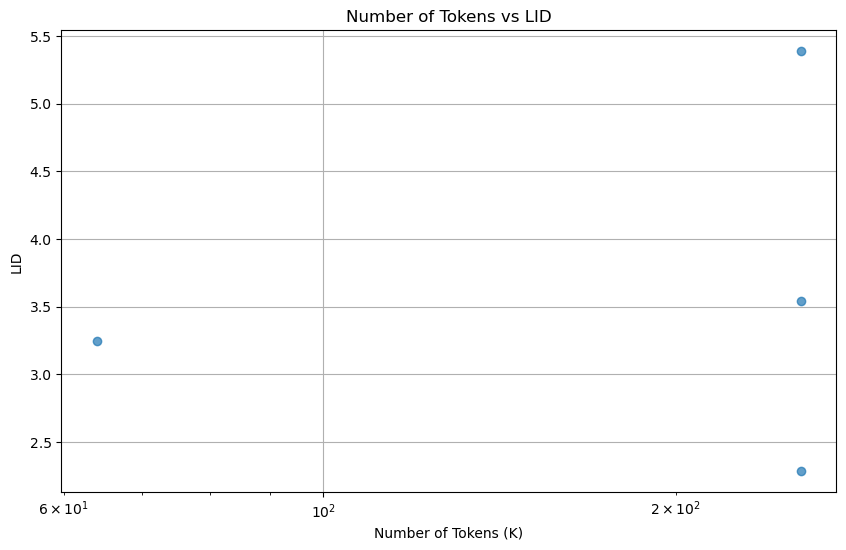

In [90]:

k_values = [recon_dataset[i]["k_value"] for i in target_indices]
print("K Values:", k_values)

# plot number of tokens vs LID

plt.figure(figsize=(10, 6))
plt.scatter(k_values, lid_filtered_values, alpha=0.7)
plt.title("Number of Tokens vs LID")
plt.xlabel("Number of Tokens (K)")
plt.ylabel("LID")
plt.xscale("log")
plt.grid(True)
plt.show()

In [103]:
# fix a vgg error value, so we can relate k value to LID
# and see how for different LID values, we need different k values.

print(np.mean(vgg_errors))
print(np.std(vgg_errors))
print(min(vgg_errors), max(vgg_errors))
error_margin = 0.05
vgg_error_reference = 0.21
vgg_filtered_indices = np.where(
    (np.array(vgg_errors) >= vgg_error_reference - error_margin) &
    (np.array(vgg_errors) <= vgg_error_reference + error_margin)
)[0]

print(vgg_filtered_indices)


2.8513830707142396
0.9189941961931493
0.2072625756263733 6.349050521850586
[16037 55723 55755 55762 55794 55826 55915 55947 55954 55977 55979 64055
 64151 64183 64247 64279]


In [104]:
# now that we have fixed the vgg error, we need to further filter so that 
# we only keep the ones with very close density values.
# then, we will be able to relate the LID values to the k values.
batch_size = 32
num_k_values = 10

# get the indices such that they map to the dataset index
indices_same_vgg_error = [recover_target_from_idx(i, batch_size, num_k_values) for i in vgg_filtered_indices]
seen = set()

# it is possible that some indices are repeated, which will happen if the same image has the same vgg error
# with different k values. however, we want to compare the LID and the k values,
# because I hypothesize that at high reconstruction errors, high LID values will require lower number of tokens.

unique_indices = [] # this is going to map to indices from the LID and density. 
original_positions = []

for idx, x in enumerate(indices_same_vgg_error):
    if x not in seen:
        seen.add(x)
        unique_indices.append(x)
        original_positions.append(idx)

print("vgg_filtered_indices:", vgg_filtered_indices)
print("Target Indices:", indices_same_vgg_error)


vgg_filtered_indices: [16037 55723 55755 55762 55794 55826 55915 55947 55954 55977 55979 64055
 64151 64183 64247 64279]
Target Indices: [1605, 5579, 5579, 5586, 5586, 5586, 5579, 5579, 5586, 5577, 5579, 6423, 6423, 6423, 6423, 6423]


In [105]:
target_indices = [indices_same_vgg_error[i] for i in original_positions]
lid_filtered_values = [lid_normalized[i] for i in unique_indices]
print("LID Filtered Values:", lid_filtered_values)  # Print first 10 LID values for verification


LID Filtered Values: [-1.2492842728062978, -0.79885232086175, -0.844318379907459, -1.1614466002620425, -1.5873786729486503]


K Values: [1, 16, 16, 16, 1]


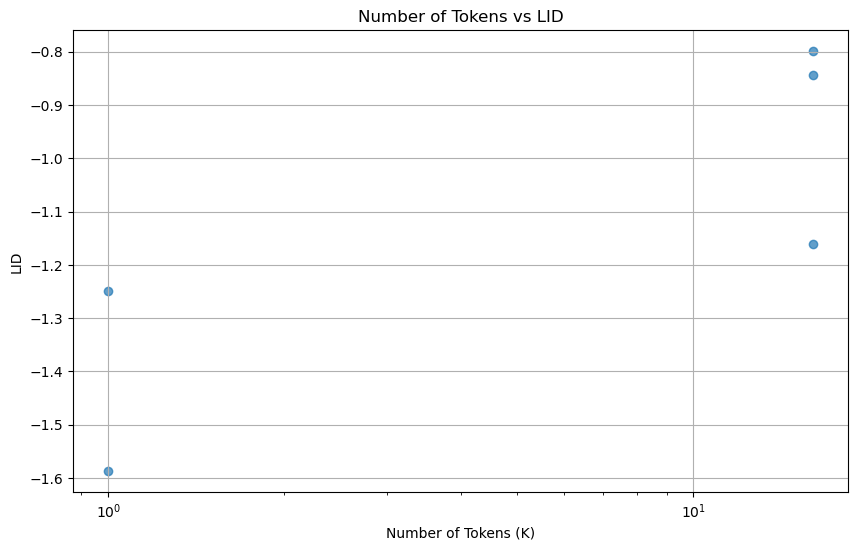

In [106]:

k_values = [recon_dataset[i]["k_value"] for i in target_indices]
print("K Values:", k_values)

# plot number of tokens vs LID

plt.figure(figsize=(10, 6))
plt.scatter(k_values, lid_filtered_values, alpha=0.7)
plt.title("Number of Tokens vs LID")
plt.xlabel("Number of Tokens (K)")
plt.ylabel("LID")
plt.xscale("log")
plt.grid(True)
plt.show()